In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

baseModel = automap_base()
# reflect the tables
baseModel.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found

baseModel.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
ref_Measurement = baseModel.classes.measurement
ref_Station = baseModel.classes.station

In [9]:
# Create our session (link) from Python to the DB
from sqlalchemy import inspect
session = Session(engine)
inspector = inspect(engine)
schema = baseModel
print(schema.classes.items())

for tbl_name in inspector.get_table_names():
    for col in inspector.get_columns(tbl_name):
        print(tbl_name, ": ", col.get('name'), ", ", col.get('type'))

[('measurement', <class 'sqlalchemy.ext.automap.measurement'>), ('station', <class 'sqlalchemy.ext.automap.station'>)]
measurement :  id ,  INTEGER
measurement :  station ,  TEXT
measurement :  date ,  TEXT
measurement :  prcp ,  FLOAT
measurement :  tobs ,  FLOAT
station :  id ,  INTEGER
station :  station ,  TEXT
station :  name ,  TEXT
station :  latitude ,  FLOAT
station :  longitude ,  FLOAT
station :  elevation ,  FLOAT


## Bonus Challenge Assignment: Temperature Analysis II

In [11]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(ref_Measurement.tobs), func.avg(ref_Measurement.tobs), func.max(ref_Measurement.tobs)).\
        filter(ref_Measurement.date >= start_date).filter(ref_Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [14]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

start_date='2012-01-01'
end_date='2012-12-31'

trip_temp=calc_temps(start_date,end_date)
#print(trip_temp)

trip_temp_df=pd.DataFrame({'start_date': start_date,
                           'end_date': end_date,
                           'min_temp': [trip_temp[0][0]],
                           'avg_temp': [trip_temp[0][1]],
                           'max_temp': [trip_temp[0][2]]
                          })
trip_temp_df.set_index(['start_date','end_date'],inplace=True)
trip_temp_df

,,min_temp,avg_temp,max_temp
start_date,end_date,,,
2012-01-01,2012-12-31,56.0,72.264015,86.0


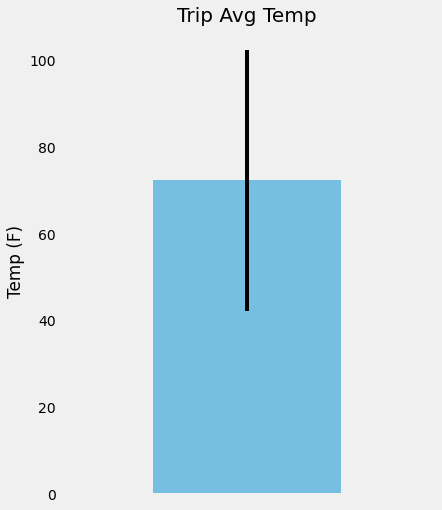

In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_df = pd.DataFrame(trip_temp, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5)
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.savefig("TripTempSummary.png")
plt.show()

### Daily Rainfall Average

In [35]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_prcp_by_station=(session.query(ref_Measurement.station,ref_Station.name,func.sum(ref_Measurement.prcp),
                                ref_Station.latitude,ref_Station.longitude,ref_Station.elevation)
                         .filter(ref_Measurement.date >= start_date)
                         .filter(ref_Measurement.date <= end_date)
                         .filter(ref_Measurement.station == ref_Station.station)
                         .group_by(ref_Measurement.station)
                         .order_by(func.sum(ref_Measurement.prcp)
                         .desc())
                         .all())

total_prcp_by_st_df=pd.DataFrame(total_prcp_by_station,
                                 columns=['station','name',
                                          'total_prcp','latitude',
                                          'longitude','elevation'])
total_prcp_by_st_df

,station,name,total_prcp,latitude,longitude,elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",122.59,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",54.90,21.45167,-157.84889,32.9
2,USC00513117,"KANEOHE 838.1, HI US",32.50,21.42340,-157.80150,14.6
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",27.76,21.33556,-157.71139,19.5
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",14.47,21.52130,-157.83740,7.0
5,USC00519397,"WAIKIKI 717.2, HI US",14.22,21.27160,-157.81680,3.0
6,USC00518838,"UPPER WAHIAWA 874.3, HI US",9.59,21.49920,-158.01110,306.6
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",9.17,21.31520,-157.99920,0.9
8,USC00517948,"PEARL CITY, HI US",2.26,21.39340,-157.97510,11.9


In [36]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(ref_Measurement.tobs), func.avg(ref_Measurement.tobs), func.max(ref_Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", ref_Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [39]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
# Strip off the year and save a list of strings in the format %m-%d
    # Use the `daily_normals` function to calculate the normals for each date string 
    # and append the results to a list called `normals`.
    
delta = dt.datetime.strptime(end_date, "%Y-%m-%d") - dt.datetime.strptime(start_date, "%Y-%m-%d")
normals = []
dates = []

for i in range(delta.days+1):
    date = dt.datetime.strptime(start_date, "%Y-%m-%d") + dt.timedelta(days=i)
    dates.append(dt.datetime.strftime(date, "%Y-%m-%d"))
    tmin,tavg,tmax = np.ravel(daily_normals(dt.datetime.strftime(date, "%m-%d")))
    normals.append((tmin,tavg,tmax))





In [40]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'], index=dates)


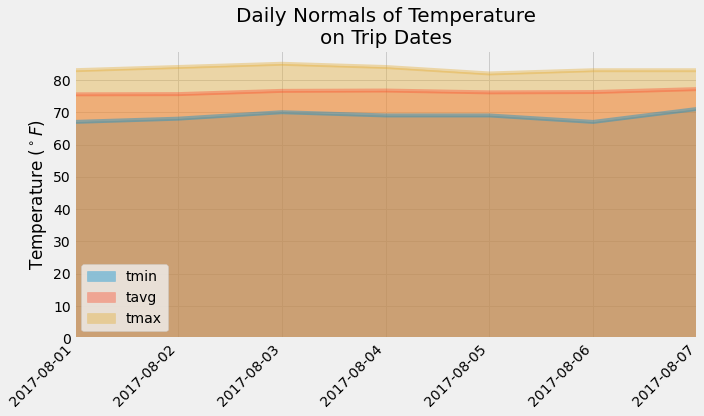

In [43]:
# Plot the daily normals as an area plot with `stacked=False`
fig, ax = plt.subplots(figsize=(10,6))
normals_df.plot.area(ax=ax, stacked=False, alpha=0.4)
plt.xticks(range(len(dates)), dates, rotation=45, ha='right')
plt.xlim((0,len(dates)-1))
plt.ylabel("Temperature ($^\circ F$)")
plt.title(f"Daily Normals of Temperature\non Trip Dates", fontsize=20, y=1)
plt.tight_layout()
plt.savefig('temperature_historical.png', bbox_inches = "tight" )

## Close Session

In [44]:
session.close()